In [1]:
!pip install scikit-learn==0.23.2
!pip install pycaret[full]
from pycaret.regression import *  #attention:must be regression

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from math import ceil

train = pd.read_csv('/content/drive/MyDrive/MLIA/Data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/content/drive/MyDrive/MLIA/Data/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/MLIA/Data/house-prices-advanced-regression-techniques/sample_submission.csv')

all_data = pd.concat([train, test], axis=0)
x_train = train.iloc[:, :79]
y_train = train.iloc[:, 80]

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

In [4]:
null_cols = [col for col in all_data.columns if all_data[col].isnull().sum() > len(all_data)/2]
null_cols
all_data.drop(null_cols,axis=1,inplace=True)

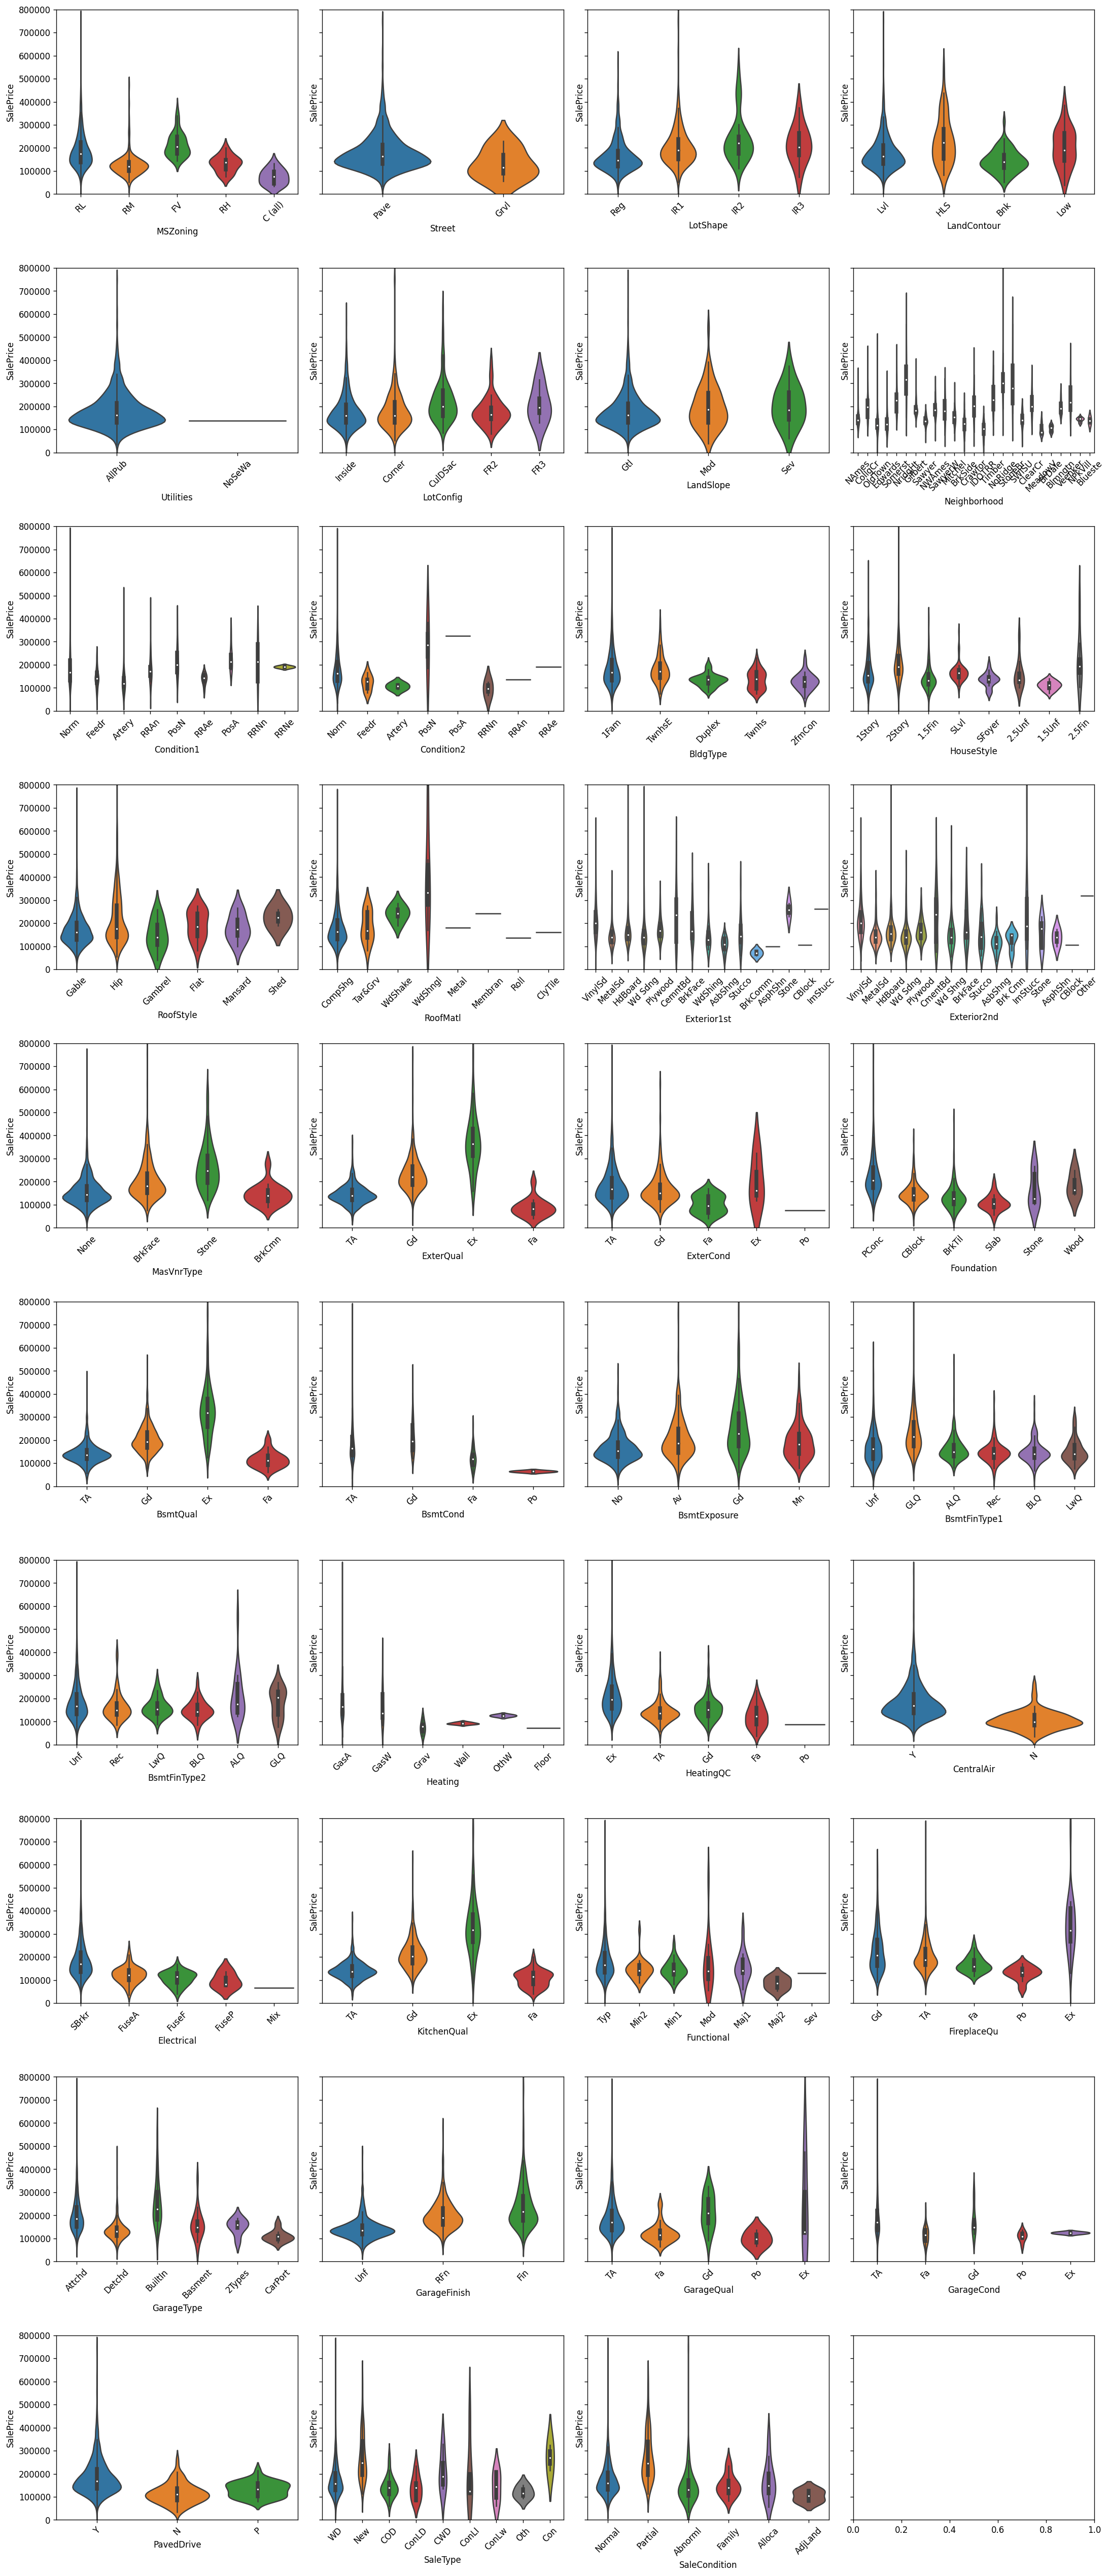

In [33]:
object_cols = all_data.select_dtypes('object').columns
fig, ax = plt.subplots(nrows=ceil(len(object_cols) / 4), ncols=4, figsize=(22, 1.4*len(object_cols)), sharey=True, dpi=120)

for col, subplot in zip(object_cols, ax.flatten()):
    freq = all_data[col].value_counts()
    subplot.ticklabel_format(style='plain')
    plt.ylim([0, 800000])
    plt.subplots_adjust(wspace=.1,hspace=.4)
    for tick in subplot.get_xticklabels():
        tick.set_rotation(45)
    sns.violinplot(data=train, x=col, y=train['SalePrice'], order=freq.index, ax=subplot)

In [5]:
all_data.drop('Utilities',axis=1,inplace=True)

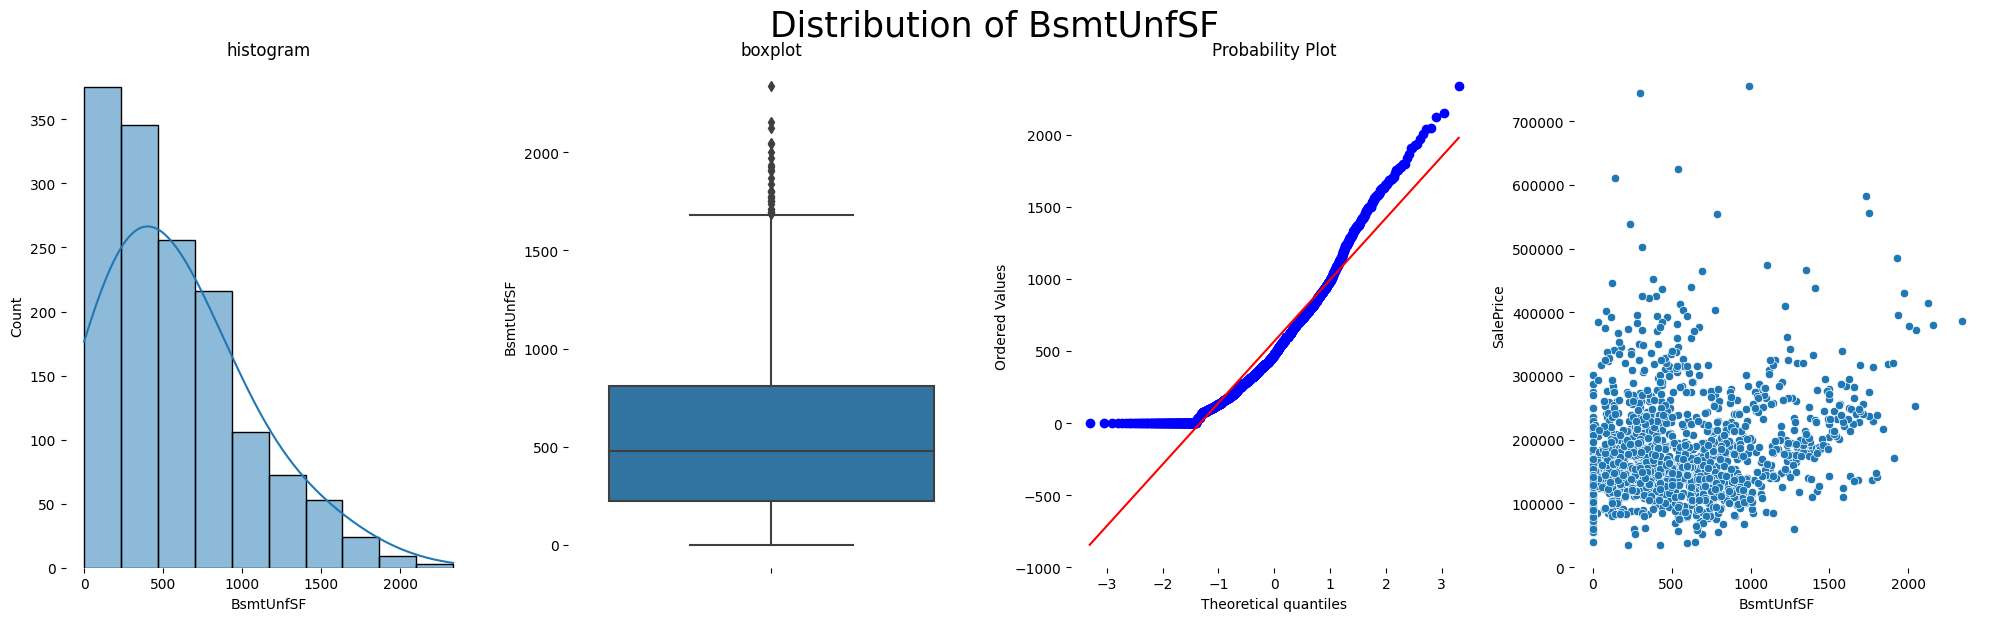

In [89]:
y = train.SalePrice
def univariate_numerical_plot(df, x):
    fig, ax = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
    
    # 0) histogram
    sns.histplot(data=df, x=x, kde=True, ax=ax[0], bins=min(df[x].nunique(),10), kde_kws={'bw_adjust':3})
    sns.despine(bottom=True, left=True)
    ax[0].set_title('histogram')
    ax[0].set_xlabel(xlabel=x)
    
    # 1) box plot
    sns.boxplot(data=df, y=x, ax=ax[1])
    ax[1].set_title('boxplot')
    ax[1].set_ylabel(ylabel=x)
    
    # 2) probability plot
    plt.sca(ax[2])
    stats.probplot(df[x], dist = "norm", plot = plt)
    
    # 3) scatterplot
    sns.scatterplot(x=df[x], y=y, ax=ax[3])
    
    fig.tight_layout()
    fig.text(0.5, 1, f'Distribution of {x}', size=25, ha="center", va="center")
    plt.show()

univariate_numerical_plot(train,'BsmtUnfSF')
print(all_data['GarageArea'].mean())
print(all_data['GarageArea'].mode()[0])

In [6]:
all_data = pd.get_dummies(all_data, drop_first=True)
all_data['LotFrontage'].fillna('69', inplace=True)
all_data['MasVnrArea'].fillna('0', inplace=True)
all_data['BsmtFinSF1'].fillna('0', inplace=True)
all_data['BsmtFinSF2'].fillna('0', inplace=True)
all_data['BsmtUnfSF'].fillna('0', inplace=True)
all_data['TotalBsmtSF'].fillna('0', inplace=True)
all_data['BsmtFullBath'].fillna('0', inplace=True)
all_data['BsmtHalfBath'].fillna('0', inplace=True)
all_data['GarageYrBlt'].fillna('2005', inplace=True)
all_data['GarageCars'].fillna('2.0', inplace=True)
all_data['GarageArea'].fillna('473', inplace=True)

In [7]:
train = all_data.iloc[:1460, :237]
test = all_data.iloc[1460:, :237].drop(['SalePrice'], axis=1)


In [9]:
print(train.shape)
print(test.shape)

(1460, 237)
(1459, 236)


In [10]:
s = setup(data=train,
          session_id=1,
          target='SalePrice',
          train_size=0.99,
          fold_strategy='stratifiedkfold',
          fold=5,
          fold_shuffle=True,
          silent=True,
          ignore_low_variance=True,
          remove_multicollinearity = True,
          normalize = True,
          normalize_method = 'robust')

,Description,Value
0,session_id,1
1,Target,SalePrice
2,Original Data,"(1460, 237)"
3,Missing Values,False
4,Numeric Features,223
5,Categorical Features,13
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1445, 169)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=['Id'],
                                      ml_usecase='regression',
                                      numerical_features=[], target='SalePrice',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_s...
                ('dummy', Dummify(target='SalePrice')),
                ('fix_perfect', Remove_100(target='SalePrice')),
                ('clean_names', Clean_Colum_Names()),

In [11]:
model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.543558e+04,6.613849e+08,2.554864e+04,8.959000e-01,0.1284,8.950000e-02,9.876
gbr,Gradient Boosting Regressor,1.713993e+04,8.157469e+08,2.837848e+04,8.717000e-01,0.1413,1.001000e-01,1.526
lightgbm,Light Gradient Boosting Machine,1.733931e+04,8.704663e+08,2.936449e+04,8.625000e-01,0.1445,1.003000e-01,0.348
xgboost,Extreme Gradient Boosting,1.847698e+04,9.308206e+08,3.028430e+04,8.537000e-01,0.1511,1.071000e-01,1.898
rf,Random Forest Regressor,1.829980e+04,9.442942e+08,3.053974e+04,8.514000e-01,0.1559,1.096000e-01,2.612
et,Extra Trees Regressor,1.894672e+04,9.774926e+08,3.112789e+04,8.452000e-01,0.1599,1.118000e-01,2.688
huber,Huber Regressor,1.632688e+04,1.007280e+09,3.080715e+04,8.386000e-01,0.1395,9.550000e-02,0.208
par,Passive Aggressive Regressor,1.783519e+04,1.115645e+09,3.274396e+04,8.224000e-01,0.1455,1.029000e-01,0.646
br,Bayesian Ridge,1.849271e+04,1.122644e+09,3.281653e+04,8.201000e-01,0.1542,1.089000e-01,0.064
ridge,Ridge Regression,1.910478e+04,1.157790e+09,3.344457e+04,8.142000e-01,0.1638,1.122000e-01,0.026


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 2
INFO:logs:<catboost.core.CatBoostRegressor object at 0x7f8e9a202110>
INFO:logs:compare_models() succesfully completed......................................


In [13]:
catboost_best = create_model('catboost')

df_pred = predict_model(catboost_best, test)
print(df_pred.head())
y_pred = df_pred.loc[:, ['Label']]
submission['SalePrice'] = y_pred
submission.to_csv('/content/drive/MyDrive/MLIA/Data/house-prices-advanced-regression-techniques/submissionv4.csv', index=False)